In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 한글 폰트 설정을 위한 코드 (이미 설정하셨다면 생략)
plt.rc('font', family='Malgun Gothic') # Windows
# plt.rc('font', family='AppleGothic') # Mac
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

In [3]:
df = pd.read_csv('C:/Users/sopi0/codes/korea-tour-recommender/data/2024_7차_전처리.csv')
df.head()

,아이디,성별,연령별,한국 방문횟수(카테고리),문1-1. 한국여행 관심 계기_1,문3-2. 고려한 관광인프라_1,여행동반자_그룹,방문 지역 수,여행 패턴,"문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)",문9-3. 총 체재기간_61일 이상 결측,문3-1. 고려한 관광활동_1순위
0,57,2,5,4,콘텐츠 및 문화,안전 및 퀄리티,가족형,1,서울 심층형,451.666667,6.0,도시 소비형
1,58,2,4,4,콘텐츠 및 문화,여행 편의성,가족형,1,서울 단기형,272.935000,5.0,경험형
2,59,2,3,3,콘텐츠 및 문화,여행 편의성,단체형,1,서울 심층형,177.650000,6.0,특수 목적
3,60,1,2,1,콘텐츠 및 문화,여행 편의성,혼자형,1,서울 심층형,153.780000,6.0,경험형
4,61,2,2,4,경험형,가성비,가족형,2,서울 단기형,329.460000,5.0,도시 소비형


In [4]:
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score

In [5]:
df.columns

Index(['아이디', '성별', '연령별', '한국 방문횟수(카테고리)', '문1-1. 한국여행 관심 계기_1',
       '문3-2. 고려한 관광인프라_1', '여행동반자_그룹', '방문 지역 수', '여행 패턴',
       '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)', '문9-3. 총 체재기간_61일 이상 결측',
       '문3-1. 고려한 관광활동_1순위'],
      dtype='object')

## '총 체재기간' 제외

In [6]:
features = ['성별', '연령별', '한국 방문횟수(카테고리)', '문1-1. 한국여행 관심 계기_1',
       '문3-2. 고려한 관광인프라_1', '여행동반자_그룹', '방문 지역 수', '여행 패턴',
       '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)', '문9-3. 총 체재기간_61일 이상 결측',
       '문3-1. 고려한 관광활동_1순위'] # '아이디'를 제외한 모든 변수

df_model = df[features].copy()

In [7]:
# 2. 수치형 데이터 스케일링 (표준화) => 순위형 범주형 변수도 포함해봄.
scaler = StandardScaler()
num_cols = ['연령별', '한국 방문횟수(카테고리)', '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
            '방문 지역 수'
            ]
df_model[num_cols] = scaler.fit_transform(df_model[num_cols])

In [8]:
# 3. 범주형 변수의 인덱스 추출 (K-prototype 입력용)
# 모델은 어떤 컬럼이 범주형인지 인덱스 번호로 인식합니다.
cat_cols = ['성별', '문1-1. 한국여행 관심 계기_1','문3-1. 고려한 관광활동_1순위', 
            '문3-2. 고려한 관광인프라_1', '여행동반자_그룹','여행 패턴']
df_model[cat_cols] = df_model[cat_cols].astype('object')

cat_idx = [df_model.columns.get_loc(col) for col in cat_cols]

In [9]:
# 4. 데이터를 Numpy Array로 변환 (kmodes 라이브러리 요구사항)
matrix = df_model.values

### gamma 설정 X

In [10]:
# --- 1. 실루엣 계산을 위한 데이터 준비 ---
# 실루엣 점수 계산 함수는 범주형 변수를 숫자로 인식해야 하므로 임시 변환이 필요합니다.
df_silhouette = df_model.copy()
le = LabelEncoder()

for col in cat_cols:
    df_silhouette[col] = le.fit_transform(df_silhouette[col])

In [11]:
# --- 2. K값 변화에 따른 실루엣 점수 계산 ---
sil_scores = []
cost = []
n_clusters = range(2, 11) # 2개에서 6개 사이 탐색

for k in n_clusters:
    # 모델 학습
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42, n_jobs=-1)
    clusters = kproto.fit_predict(matrix, categorical=cat_idx)
    cost.append(kproto.cost_)
    
    # 실루엣 점수 계산 (여기서는 변환된 df_silhouette를 사용)
    # 주의: K-prototype의 내부 거리 로직과 100% 일치하지는 않지만, 군집의 품질을 판단하는 좋은 지표가 됩니다.
    score = silhouette_score(df_silhouette, clusters)
    sil_scores.append(score)
    print(f"Cluster k={k}, Silhouette Score: {score:.4f}")

Cluster k=2, Silhouette Score: 0.5404
Cluster k=3, Silhouette Score: 0.3158
Cluster k=4, Silhouette Score: 0.1527
Cluster k=5, Silhouette Score: 0.1168
Cluster k=6, Silhouette Score: 0.0960
Cluster k=7, Silhouette Score: 0.0843
Cluster k=8, Silhouette Score: 0.0722
Cluster k=9, Silhouette Score: 0.0883
Cluster k=10, Silhouette Score: 0.0775


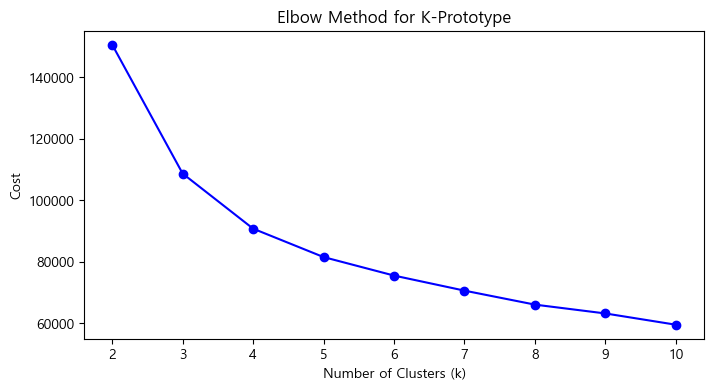

In [12]:
# Elbow Plot 시각화
plt.figure(figsize=(8, 4))
plt.plot(n_clusters, cost, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for K-Prototype')
plt.show()

In [14]:
for k in n_clusters:
    print(f"k = {k}, cost = {cost[k-2]}")

k = 2, cost = 150648.38082844205
k = 3, cost = 108682.4535342207
k = 4, cost = 90745.83588256635
k = 5, cost = 81494.04489038438
k = 6, cost = 75470.24890096996
k = 7, cost = 70564.80780809095
k = 8, cost = 66006.91185712465
k = 9, cost = 63132.68010653708
k = 10, cost = 59463.720827542485


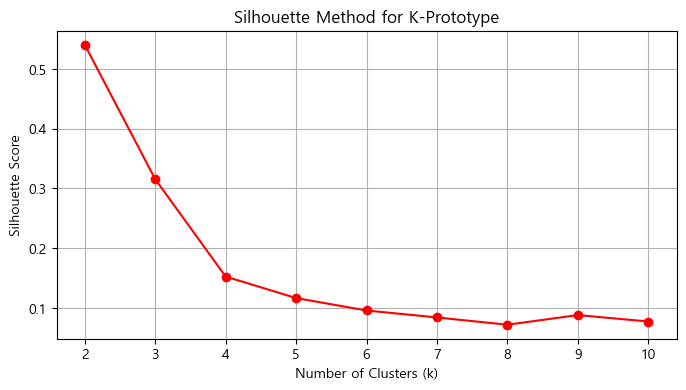

In [13]:
# --- 3. 실루엣 그래프 시각화 ---
plt.figure(figsize=(8, 4))
plt.plot(n_clusters, sil_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for K-Prototype')
plt.grid(True)
plt.show()

#### 최적의 k일 때 클러스터 확인하기 (1)

In [16]:
kproto = KPrototypes(n_clusters=4, init='Cao', random_state=42, n_jobs=-1)
clusters = kproto.fit_predict(matrix, categorical=cat_idx)

In [17]:
pd.Series(clusters).value_counts().sort_index()

0     212
1    5665
2     992
3    3262
Name: count, dtype: int64

In [18]:
# 원본 데이터에 클러스터 결과 붙이기
df_model['Cluster'] = clusters
# 클러스터별 중심점(Centroids) 확인
print(kproto.cluster_centroids_)

[['-0.37882439660302814' '-0.01717482816999802' '1.3625085803986443'
  '-0.7657102366847843' '27.952830188679247' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '혼자형' '서울 심층형']
 ['0.0986424940411462' '0.13329487859261788' '-0.2949297835154661'
  '0.13486425615011813' '4.155692850838482' '2' '콘텐츠 및 문화' '도시 소비형'
  '여행 편의성' '가족형' '서울 단기형']
 ['-0.22540039619532715' '-0.2995208587823833' '0.999396218944816'
  '-0.3726968728032136' '13.553427419354838' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '가족형' '서울 심층형']
 ['-0.07814278468348483' '-0.13928563204875083' '0.11971929962518277'
  '-0.07110979248695887' '7.266094420600858' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '가족형' '서울 심층형']]


#### 최적의 k일 때 클러스터 확인하기 (2)

In [19]:
kproto = KPrototypes(n_clusters=5, init='Cao', random_state=42, n_jobs=-1)
clusters = kproto.fit_predict(matrix, categorical=cat_idx)

In [20]:
pd.Series(clusters).value_counts().sort_index()

0     552
1    1133
2    5491
3     115
4    2840
Name: count, dtype: int64

In [21]:
# 원본 데이터에 클러스터 결과 붙이기
df_model['Cluster'] = clusters
# 클러스터별 중심점(Centroids) 확인
print(kproto.cluster_centroids_)

[['-0.2688349268537144' '-0.26277813123173455' '1.1792901770760158'
  '-0.5053697092731383' '16.809782608695652' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '가족형' '서울 심층형']
 ['-0.19886687157100308' '-0.2465766959032284' '0.7022821566095397'
  '-0.22241402343269506' '10.546337157987644' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '가족형' '서울 심층형']
 ['0.095673171824068' '0.13762093222996027' '-0.3236738582839206'
  '0.13399531461931072' '4.118375523584047' '2' '콘텐츠 및 문화' '도시 소비형'
  '여행 편의성' '가족형' '서울 단기형']
 ['-0.4201334188294883' '0.025999709551819253' '1.2420227869906666'
  '-0.8632752032430261' '32.95652173913044' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '혼자형' '서울 심층형']
 ['-0.03637781627020444' '-0.11769069738551441' '0.06612911061571373'
  '-0.037159315540024905' '6.684154929577465' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '가족형' '서울 심층형']]


## gamma 설정 O (Grid Search)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes

# -----------------------------
# 1) 탐색 그리드 설정
# -----------------------------
k_list = list(range(2, 11))
gamma_list = [0.1, 0.25, 0.5, 1, 2, 4, 8, 16]  # 필요하면 더 촘촘히

# 결과 저장용
rows = []
# 실루엣 점수 저장
sil_scores = []

# -----------------------------
# 2) k x gamma 그리드 탐색
# -----------------------------
for k in k_list:
    for g in gamma_list:
        kproto = KPrototypes(
            n_clusters=k,
            init='Cao',
            # n_init=20,          # 안정성 위해 권장(기본 10보다 크게)
            # max_iter=100,
            gamma=g,            # <-- 여기서 gamma 지정
            verbose=0,
            random_state=42
        )
        labels = kproto.fit_predict(matrix, categorical=cat_idx)
        
        # cost
        cost = kproto.cost_
        
        # 실루엣 점수 계산 (여기서는 변환된 df_silhouette를 사용)
        # 주의: K-prototype의 내부 거리 로직과 100% 일치하지는 않지만, 군집의 품질을 판단하는 좋은 지표가 됩니다.
        score = silhouette_score(df_silhouette, labels)
        sil_scores.append(score)
        print(f"Cluster k={k}, Silhouette Score: {score:.4f}, cost: {cost:.4f}")


        # 군집 크기 불균형 지표(해석에 유용)
        counts = np.bincount(labels, minlength=k)
        proportions = counts / counts.sum()
        max_cluster_ratio = proportions.max()  # 가장 큰 군집 비율 (너무 크면 불균형)

        # 엔트로피(균형도): 클수록 더 고르게 퍼짐(최대는 log(k))
        eps = 1e-12
        entropy = -(proportions * np.log(proportions + eps)).sum()
        entropy_norm = entropy / np.log(k)     # 0~1로 정규화(1에 가까울수록 균형)

        rows.append({
            "k": k,
            "gamma": g,
            "cost": cost,
            "silhouette_score": score,
            "max_cluster_ratio": max_cluster_ratio,
            "entropy_norm": entropy_norm
        })

result = pd.DataFrame(rows)


Cluster k=2, Silhouette Score: 0.5406, cost: 126995.3476
Cluster k=2, Silhouette Score: 0.5406, cost: 131697.0976
Cluster k=2, Silhouette Score: 0.5406, cost: 139533.3476
Cluster k=2, Silhouette Score: 0.5404, cost: 155205.4220
Cluster k=2, Silhouette Score: 0.5032, cost: 186314.8109
Cluster k=2, Silhouette Score: 0.5027, cost: 248402.2198
Cluster k=2, Silhouette Score: 0.4746, cost: 371860.4631
Cluster k=2, Silhouette Score: 0.2128, cost: 601028.1359
Cluster k=3, Silhouette Score: 0.3174, cost: 86182.8204
Cluster k=3, Silhouette Score: 0.3169, cost: 90657.9706
Cluster k=3, Silhouette Score: 0.3158, cost: 98112.8395
Cluster k=3, Silhouette Score: 0.3155, cost: 113015.5721
Cluster k=3, Silhouette Score: 0.3153, cost: 142808.6585
Cluster k=3, Silhouette Score: 0.1962, cost: 202930.5488
Cluster k=3, Silhouette Score: 0.1591, cost: 309675.1554
Cluster k=3, Silhouette Score: 0.1050, cost: 549010.0849
Cluster k=4, Silhouette Score: 0.1930, cost: 68784.1844
Cluster k=4, Silhouette Score: 0.19

In [31]:
result

,k,gamma,cost,silhouette_score,max_cluster_ratio,entropy_norm
0,2,0.10,126995.347618,0.540588,0.907808,0.443745
1,2,0.25,131697.097618,0.540588,0.907808,0.443745
2,2,0.50,139533.347618,0.540588,0.907808,0.443745
3,2,1.00,155205.422006,0.540449,0.907709,0.444071
4,2,2.00,186314.810888,0.503226,0.881749,0.524312
...,...,...,...,...,...,...
67,10,1.00,63260.353971,0.077425,0.209357,0.880426
68,10,2.00,90041.037220,0.065142,0.195341,0.890880
69,10,4.00,135120.140167,0.054362,0.225151,0.892440
70,10,8.00,218454.192682,0.027030,0.190504,0.933278


In [34]:
result['gamma'].unique()

array([ 0.1 ,  0.25,  0.5 ,  1.  ,  2.  ,  4.  ,  8.  , 16.  ])

In [39]:
result_tmp = result[result['gamma']<4]

<Axes: xlabel='k', ylabel='cost'>

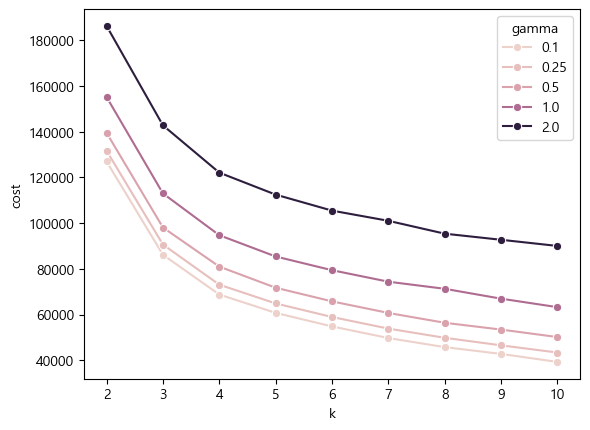

In [40]:
sns.lineplot(data=result_tmp, x='k',y='cost',hue='gamma', marker='o')

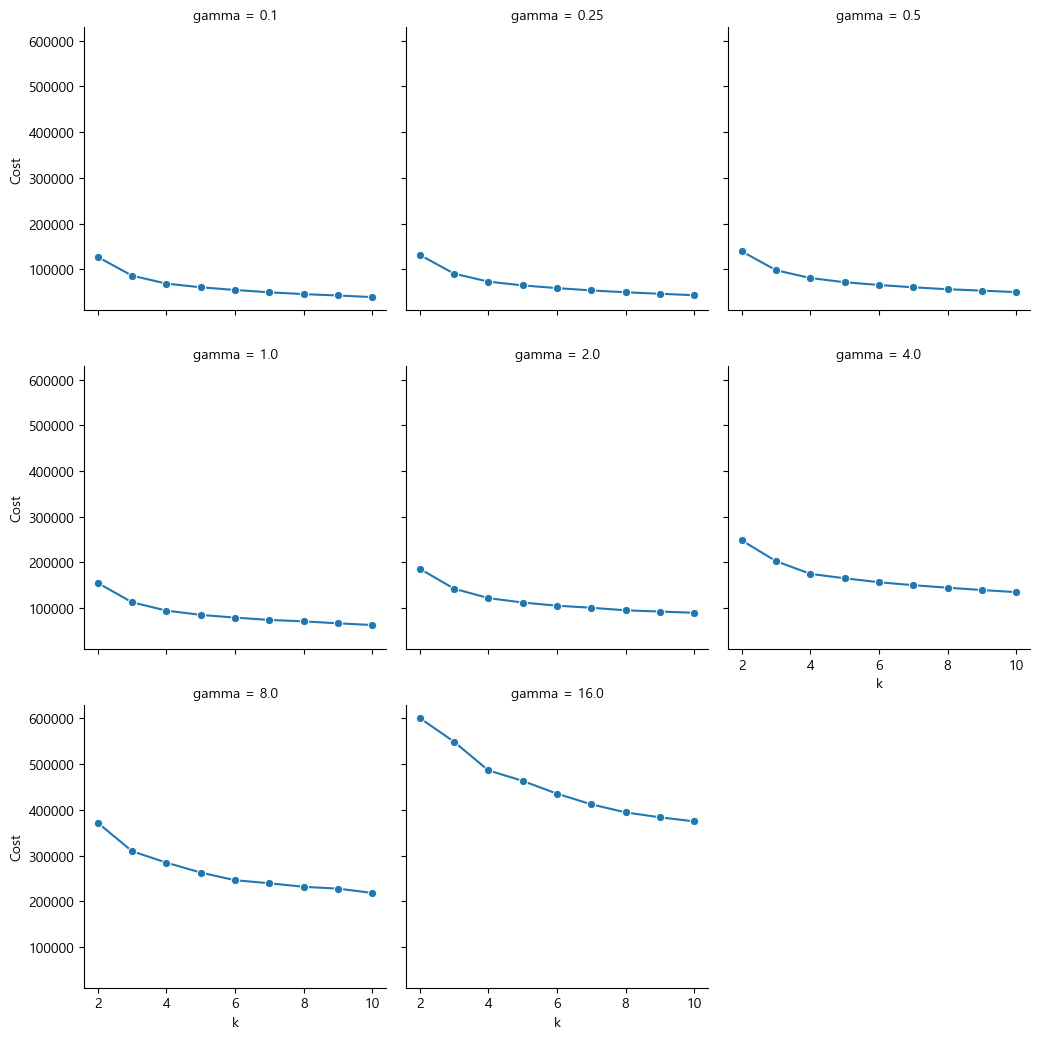

In [36]:
g = sns.FacetGrid(
    result,
    col='gamma',
    col_wrap=3,
    height=3.5,
    sharey=True
)

g.map_dataframe(sns.lineplot, x='k', y='cost', marker='o')
g.set_axis_labels('k', 'Cost')
g.set_titles('gamma = {col_name}')
plt.tight_layout()
plt.show()

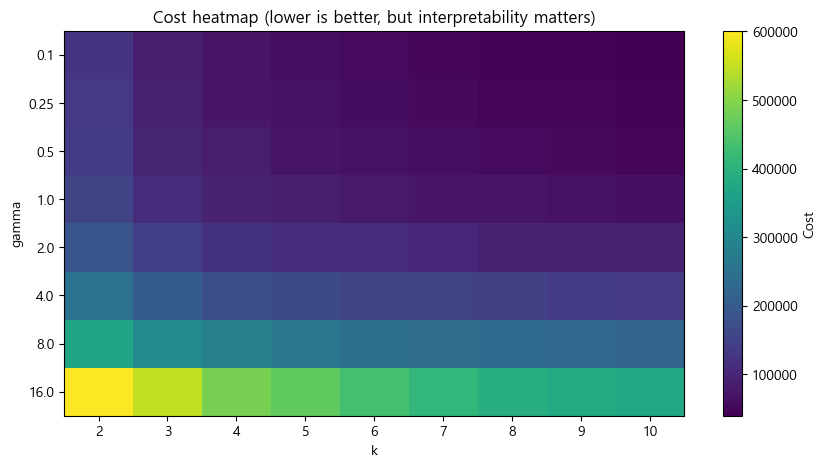

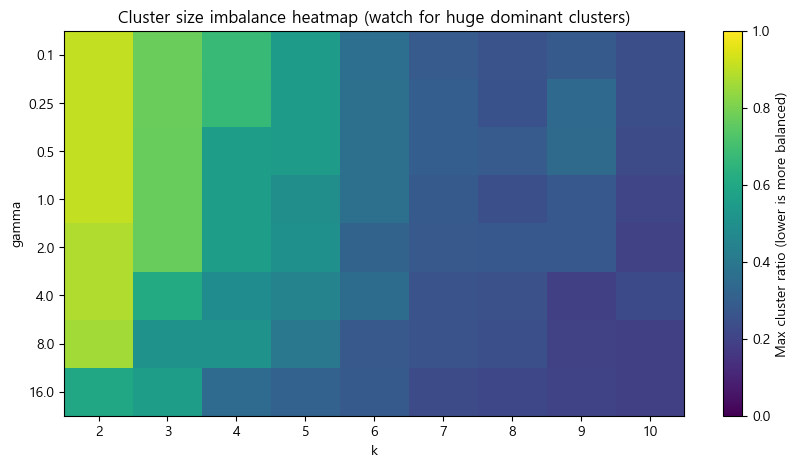

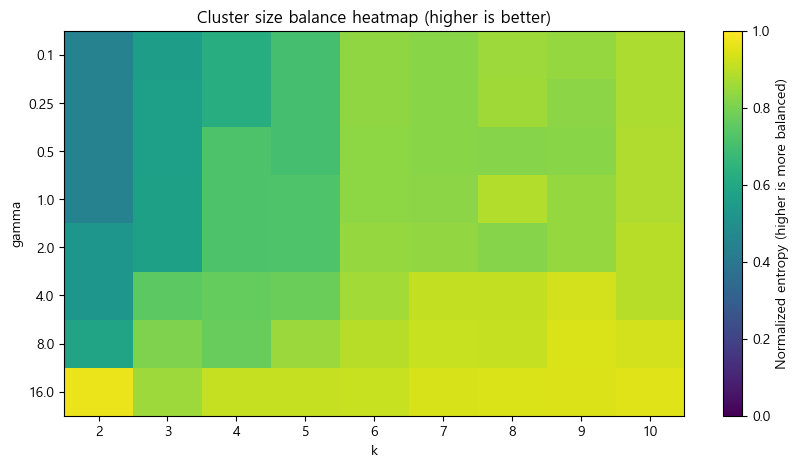

In [22]:

# -----------------------------
# 3) 결과 확인: (a) cost heatmap 형태로 보기
# -----------------------------
pivot_cost = result.pivot(index="gamma", columns="k", values="cost").sort_index()
plt.figure(figsize=(10, 5))
plt.imshow(pivot_cost.values, aspect='auto')
plt.yticks(range(len(pivot_cost.index)), pivot_cost.index)
plt.xticks(range(len(pivot_cost.columns)), pivot_cost.columns)
plt.colorbar(label="Cost")
plt.xlabel("k")
plt.ylabel("gamma")
plt.title("Cost heatmap (lower is better, but interpretability matters)")
plt.show()

# -----------------------------
# 4) 결과 확인: (b) 불균형/균형도도 같이 보기
# -----------------------------
pivot_max = result.pivot(index="gamma", columns="k", values="max_cluster_ratio").sort_index()
plt.figure(figsize=(10, 5))
plt.imshow(pivot_max.values, aspect='auto', vmin=0, vmax=1)
plt.yticks(range(len(pivot_max.index)), pivot_max.index)
plt.xticks(range(len(pivot_max.columns)), pivot_max.columns)
plt.colorbar(label="Max cluster ratio (lower is more balanced)")
plt.xlabel("k")
plt.ylabel("gamma")
plt.title("Cluster size imbalance heatmap (watch for huge dominant clusters)")
plt.show()

pivot_ent = result.pivot(index="gamma", columns="k", values="entropy_norm").sort_index()
plt.figure(figsize=(10, 5))
plt.imshow(pivot_ent.values, aspect='auto', vmin=0, vmax=1)
plt.yticks(range(len(pivot_ent.index)), pivot_ent.index)
plt.xticks(range(len(pivot_ent.columns)), pivot_ent.columns)
plt.colorbar(label="Normalized entropy (higher is more balanced)")
plt.xlabel("k")
plt.ylabel("gamma")
plt.title("Cluster size balance heatmap (higher is better)")
plt.show()

#### 최적의 k일 때 클러스터 확인하기 (1) - k=3, gamma=1

In [44]:
result[result['k']==3]

,k,gamma,cost,silhouette_score,max_cluster_ratio,entropy_norm
8,3,0.10,86182.820413,0.317379,0.771197,0.562282
9,3,0.25,90657.970554,0.316879,0.770210,0.563477
10,3,0.50,98112.839471,0.315821,0.768137,0.565969
11,3,1.00,113015.572138,0.315464,0.767446,0.566794
12,3,2.00,142808.658542,0.315281,0.766953,0.567382
13,3,4.00,202930.548849,0.196211,0.609811,0.748754
14,3,8.00,309675.155425,0.159107,0.508834,0.806937
15,3,16.00,549010.084887,0.105041,0.557102,0.852884


In [23]:
# kproto = KPrototypes(n_cluste7rs=5, init='Cao', random_state=42, n_jobs=-1)
kproto = KPrototypes(
            n_clusters=3,
            init='Cao',
            # n_init=20,          # 안정성 위해 권장(기본 10보다 크게)
            # max_iter=100,
            gamma=1,            # <-- 여기서 gamma 지정
            verbose=0,
            random_state=42
        )
clusters = kproto.fit_predict(matrix, categorical=cat_idx)

In [24]:
pd.Series(clusters).value_counts().sort_index()

0     258
1    2098
2    7775
Name: count, dtype: int64

In [25]:
# 원본 데이터에 클러스터 결과 붙이기
df_model['Cluster'] = clusters
# 클러스터별 중심점(Centroids) 확인
print(kproto.cluster_centroids_)

[['-0.3118656307407374' '-0.08670832537482527' '1.4891299080016904'
  '-0.7279391436507534' '26.434108527131784' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '혼자형' '서울 심층형']
 ['-0.19493903372713442' '-0.24635656213674356' '0.6417891906895457'
  '-0.2634705888542002' '10.794089609151573' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '가족형' '서울 심층형']
 ['0.0629509228926813' '0.0693539312295271' '-0.22259411425476422'
  '0.09525010861453415' '4.778006430868167' '2' '경험형' '도시 소비형' '여행 편의성'
  '가족형' '서울 단기형']]


#### 최적의 k일 때 클러스터 확인하기 (2) - k=4, gamma=2

In [45]:
result[result['k']==4]

,k,gamma,cost,silhouette_score,max_cluster_ratio,entropy_norm
16,4,0.10,68784.184406,0.193003,0.672688,0.622888
17,4,0.25,73093.587596,0.192522,0.670418,0.624599
18,4,0.50,81001.699743,0.152732,0.557299,0.720914
19,4,1.00,94737.993999,0.152654,0.560655,0.719580
20,4,2.00,122122.661794,0.151244,0.562037,0.719020
21,4,4.00,175155.044945,0.139164,0.485145,0.765229
22,4,8.00,284651.480439,0.105375,0.508242,0.768775
23,4,16.00,486473.571523,0.090289,0.350015,0.912745


In [26]:
kproto = KPrototypes(
            n_clusters=4,
            init='Cao',
            # n_init=20,          # 안정성 위해 권장(기본 10보다 크게)
            # max_iter=100,
            gamma=2,            # <-- 여기서 gamma 지정
            verbose=0,
            random_state=42
        )
clusters = kproto.fit_predict(matrix, categorical=cat_idx)

In [27]:
pd.Series(clusters).value_counts().sort_index()

0    5694
1     212
2    3233
3     992
Name: count, dtype: int64

In [28]:
# 원본 데이터에 클러스터 결과 붙이기
df_model['Cluster'] = clusters
# 클러스터별 중심점(Centroids) 확인
print(kproto.cluster_centroids_)

[['0.09872544983999053' '0.1378486977766905' '-0.30600311961442905'
  '0.1339459408706462' '4.1738672286617495' '2' '콘텐츠 및 문화' '도시 소비형'
  '여행 편의성' '가족형' '서울 단기형']
 ['-0.3788243966030287' '-0.017174828169922333' '1.3625085803986074'
  '-0.7657102366847843' '27.952830188679247' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '혼자형' '서울 심층형']
 ['-0.07987465087637362' '-0.1497509216382046' '0.1429411985297887'
  '-0.07134003072053734' '7.261985771729044' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '가족형' '서울 심층형']
 ['-0.22540039619530866' '-0.29952085878234197' '0.9993962189447958'
  '-0.37269687280321373' '13.553427419354838' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '가족형' '서울 심층형']]


#### 최적의 k일 때 클러스터 확인하기 (2) - k=4, gamma=1

In [41]:
kproto = KPrototypes(
            n_clusters=4,
            init='Cao',
            # n_init=20,          # 안정성 위해 권장(기본 10보다 크게)
            # max_iter=100,
            gamma=1,            # <-- 여기서 gamma 지정
            verbose=0,
            random_state=42
        )
clusters = kproto.fit_predict(matrix, categorical=cat_idx)

In [42]:
pd.Series(clusters).value_counts().sort_index()

0     212
1    3247
2    5680
3     992
Name: count, dtype: int64

In [43]:
# 원본 데이터에 클러스터 결과 붙이기
df_model['Cluster'] = clusters
# 클러스터별 중심점(Centroids) 확인
print(kproto.cluster_centroids_)

[['-0.37882439660302863' '-0.017174828169921864' '1.3625085803986394'
  '-0.7657102366847809' '27.952830188679247' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '혼자형' '서울 심층형']
 ['-0.08070088003323941' '-0.14359893129078427' '0.12292893470393233'
  '-0.07052602426511255' '7.271943332306745' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '가족형' '서울 심층형']
 ['0.09963797932632075' '0.1350407544692501' '-0.2956695632432067'
  '0.1339865966173913' '4.16056338028169' '2' '콘텐츠 및 문화' '도시 소비형'
  '여행 편의성' '가족형' '서울 단기형']
 ['-0.22540039619531016' '-0.29952085878233753' '0.9993962189447884'
  '-0.3726968728032139' '13.553427419354838' '2' '경험형' '역사, 전통, 자연'
  '여행 편의성' '가족형' '서울 심층형']]


전반적으로 범주형 변수들은 다 비슷하게 나오는 듯... 

편향되어있는지 다시 확인하기

수치형 변수들은 어떻게 클러스터링 됐는지 확인해보기

# 수치형 변수 분포 확인

In [46]:
df

,아이디,성별,연령별,한국 방문횟수(카테고리),문1-1. 한국여행 관심 계기_1,문3-2. 고려한 관광인프라_1,여행동반자_그룹,방문 지역 수,여행 패턴,"문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)",문9-3. 총 체재기간_61일 이상 결측,문3-1. 고려한 관광활동_1순위
0,57,2,5,4,콘텐츠 및 문화,안전 및 퀄리티,가족형,1,서울 심층형,451.666667,6.0,도시 소비형
1,58,2,4,4,콘텐츠 및 문화,여행 편의성,가족형,1,서울 단기형,272.935000,5.0,경험형
2,59,2,3,3,콘텐츠 및 문화,여행 편의성,단체형,1,서울 심층형,177.650000,6.0,특수 목적
3,60,1,2,1,콘텐츠 및 문화,여행 편의성,혼자형,1,서울 심층형,153.780000,6.0,경험형
4,61,2,2,4,경험형,가성비,가족형,2,서울 단기형,329.460000,5.0,도시 소비형
...,...,...,...,...,...,...,...,...,...,...,...,...
10126,19271,2,2,1,가성비 및 접근성,안전 및 퀄리티,친구형,1,수도권/지방형(탐험가형),126.316000,5.0,"역사, 전통, 자연"
10127,19273,2,4,2,가성비 및 접근성,안전 및 퀄리티,친구형,1,수도권/지방형(탐험가형),112.586000,5.0,"역사, 전통, 자연"
10128,19274,1,4,2,콘텐츠 및 문화,가성비,가족형,1,수도권/지방형(탐험가형),52.860500,5.0,특수 목적
10129,19275,2,5,1,가성비 및 접근성,안전 및 퀄리티,가족형,1,수도권/지방형(탐험가형),535.470000,5.0,특수 목적


In [47]:
num_cols = ['연령별', '한국 방문횟수(카테고리)', '문10. 1인 1일 지출경비(상하위 1% 대체, 61일 이상 결측)',
            '방문 지역 수']

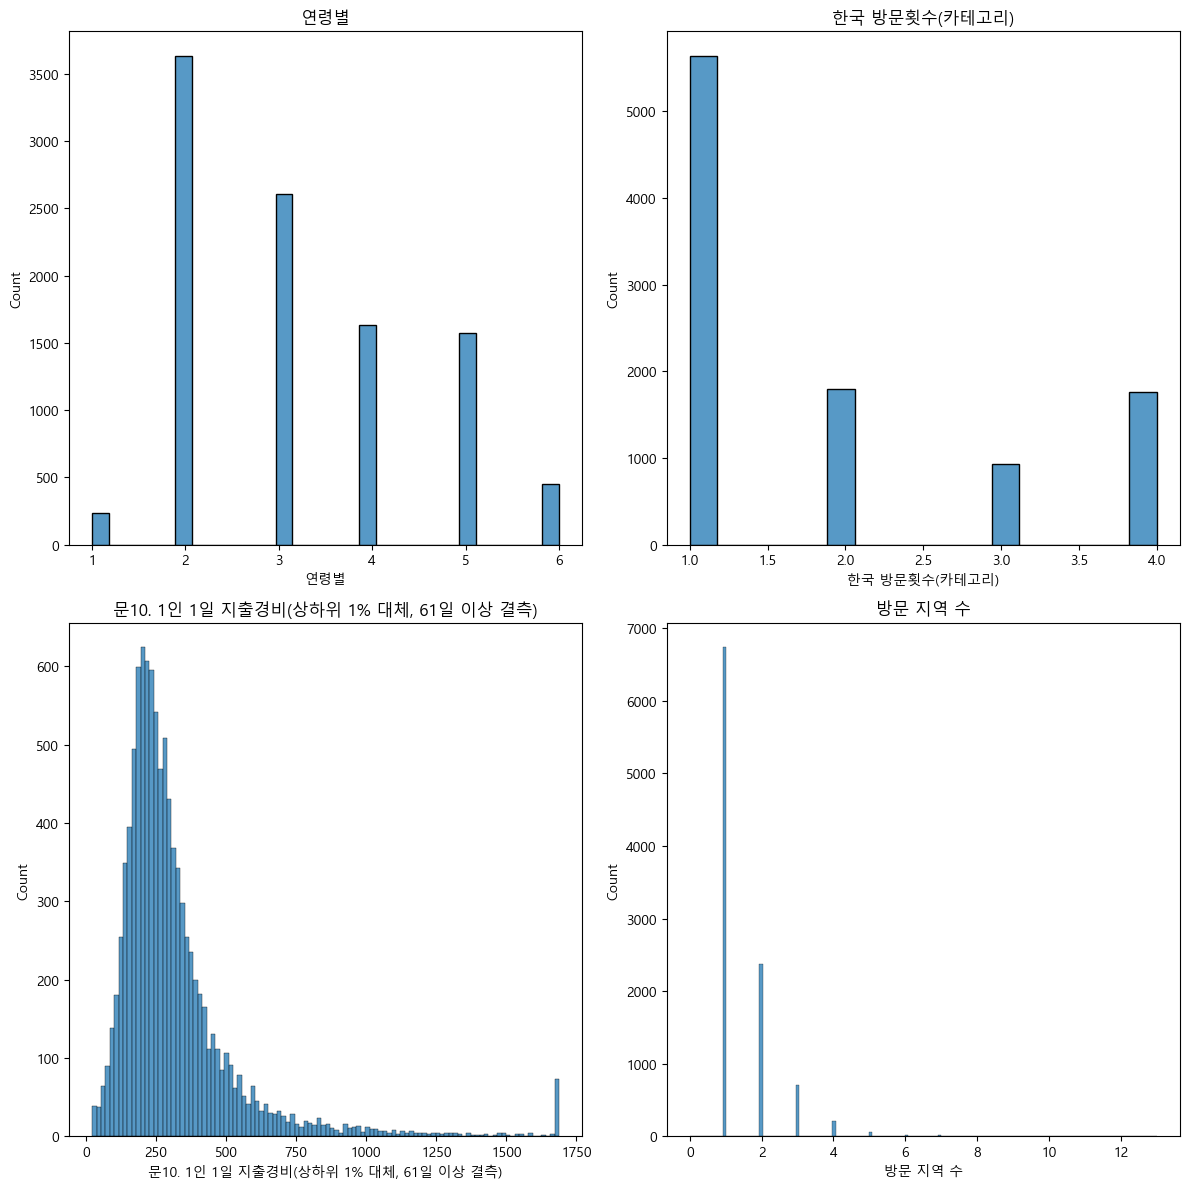

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

for i in range(4):
    sns.histplot(data=df, x=num_cols[i], ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(num_cols[i])
    
plt.tight_layout()
plt.show()